# HEATPIPE Demo
This notebook showcases the core capabilities: fluids, pressure breakdowns, limits vs temperature, geometry sweeps, and config I/O.

In [1]:

import sys, pathlib
from heatpipe.fluids import Fluid, properties_cgs, tsat_from_p_cgs
from heatpipe import fluids
from heatpipe import fluids as F
from heatpipe import __dict__ as _heatpipe_dict
from heatpipe import *
from heatpipe.io import PipeConfig, Geometry, SectionLengths, FlowFlags, Option, load_config, dump_config_file, props_for
from heatpipe.plotting import plot_limits_vs_temperature, plot_pressure_breakdown, plot_Q_vs_geometry
from heatpipe.models import Regime, SectionLengths as M_SectionLengths, Geometry as M_Geometry, FlowFlags as M_FlowFlags, pressure_breakdown_cgs, estimate_limits_cgs
print("Ready.")


Ready.


## 1. Fluids: PV(T), TSAT(P), densities, viscosities, sigma, h_fg

In [2]:
import pandas as pd
rows = []
Ts = [350, 500, 700, 900]
for f in [Fluid.WATER, Fluid.SODIUM, Fluid.POTASSIUM, Fluid.LITHIUM, Fluid.MERCURY]:
    for T in Ts:
        P = properties_cgs(f, T)
        rows.append(dict(fluid=f.value, T_K=T, p_sat_dyn_cm2=P.pv, rho_l_g_cm3=P.rhol, rho_v_g_cm3=P.rhov, mu_l_P=P.mul, mu_v_P=P.muv, sigma_dyn_cm=P.sigma, h_fg_kJ_kg=P.hfg, gamma=P.gamma))
df = pd.DataFrame(rows)
df.head()


,fluid,T_K,p_sat_dyn_cm2,rho_l_g_cm3,rho_v_g_cm3,mu_l_P,mu_v_P,sigma_dyn_cm,h_fg_kJ_kg,gamma
0,water,350,3.580618e+05,1.0000,2.214891e-04,0.004244,0.000122,61.75,2283.450000,1.324
1,water,500,2.331158e+07,0.7900,1.009402e-02,0.001196,0.000222,31.00,1633.500000,1.324
2,water,700,3.772659e+08,0.5100,1.166842e-01,0.000514,0.000681,-10.00,766.900000,1.324
3,water,900,1.771562e+09,0.2300,4.261636e-01,0.000321,0.003036,-51.00,-99.700000,1.324
4,sodium,350,3.122969e-05,0.9361,2.468411e-14,0.001094,0.000051,188.15,4748.085168,1.667


### Inversion check: TSAT(PV(T)) ≈ T

In [3]:
import math
for f in [Fluid.WATER, Fluid.SODIUM]:
    for T in [350.0, 500.0, 700.0]:
        P = properties_cgs(f, T).pv
        Tinvert = tsat_from_p_cgs(f, P)
        print(f"{f.value:>8} T={T:.1f} K -> PV={P:.3e} dyn/cm^2 -> TSAT(P)={Tinvert:.2f} K  (err={Tinvert-T:+.3e} K)")


   water T=350.0 K -> PV=3.581e+05 dyn/cm^2 -> TSAT(P)=350.00 K  (err=+0.000e+00 K)
   water T=500.0 K -> PV=2.331e+07 dyn/cm^2 -> TSAT(P)=500.00 K  (err=+0.000e+00 K)
   water T=700.0 K -> PV=3.773e+08 dyn/cm^2 -> TSAT(P)=700.00 K  (err=+0.000e+00 K)
  sodium T=350.0 K -> PV=3.123e-05 dyn/cm^2 -> TSAT(P)=350.58 K  (err=+5.757e-01 K)
  sodium T=500.0 K -> PV=1.050e+00 dyn/cm^2 -> TSAT(P)=500.82 K  (err=+8.224e-01 K)
  sodium T=700.0 K -> PV=1.094e+03 dyn/cm^2 -> TSAT(P)=701.15 K  (err=+1.151e+00 K)


## 2. Pressure-drop budget and compressible adiabatic treatment

Pressure breakdown (dyn/cm^2): {'dp_fric_evap': 3869.5501105295084, 'dp_inert_evap': 16562.92837555661, 'dp_fric_cond': 3869.5501105295084, 'dp_adiabatic': 8251.14061573831, 'dp_hydro': 0.0, 'dp_capillary': 13810.000000000002, 'choked_adiab': False, 'M_out_adiab': 0.46376809772045346}


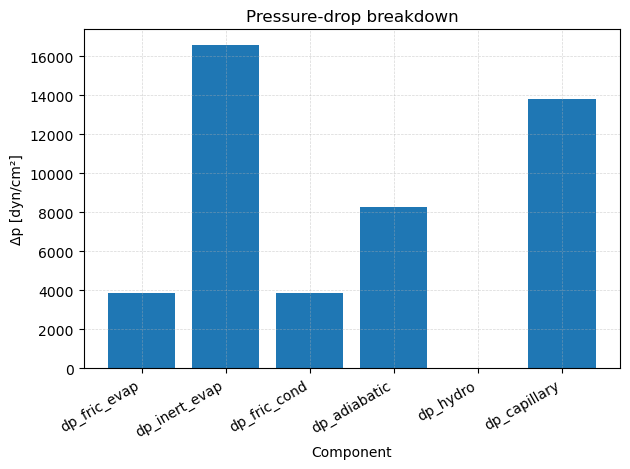

In [4]:

# Define a pipe and state
geom = M_Geometry(radius_cm=0.5, effective_pore_radius_cm=0.02, wavelength_cm=0.05)
lengths = M_SectionLengths(L_e=30.0, L_a=20.0, L_c=30.0)
flags = M_FlowFlags(vapor_regime_evap=Regime.LAMINAR, vapor_regime_adiab=Regime.TURBULENT, vapor_regime_cond=Regime.LAMINAR)
T = 900.0
f = props_for("sodium", T)

# Choose a trial mass flow (g/s); a rough value from power guess Q ≈ m_dot * h_fg
Q_guess_W = 1500.0
h_fg_J_kg = f["h_fg"] * 1e3
m_dot = Q_guess_W / h_fg_J_kg * 1e3  # kg/s -> g/s

pb = pressure_breakdown_cgs(lengths, geom, f, flags, m_dot, theta_deg=0.0)
pb_dict = pb.__dict__.copy()
print("Pressure breakdown (dyn/cm^2):", pb_dict)
plot_pressure_breakdown({k: float(v) for k,v in pb_dict.items() if k.startswith("dp_")});


## 3. Limits vs temperature (Option 2 style sweep)

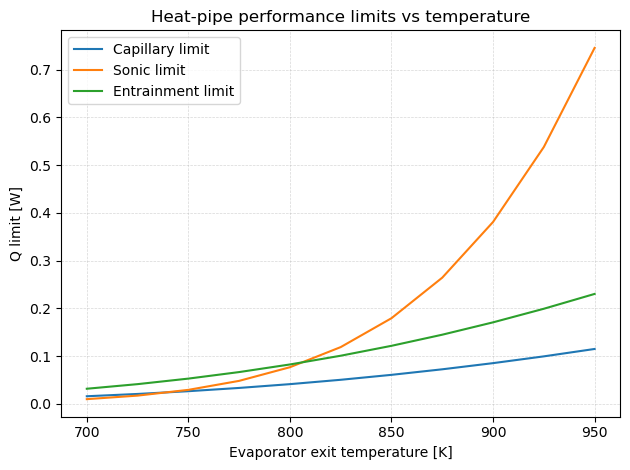

In [5]:
Ts = list(range(700, 951, 25))
q_cap, q_sonic, q_ent = [], [], []
for T in Ts:
    f = props_for("sodium", float(T))
    lims = estimate_limits_cgs(lengths, geom, f, flags)
    q_cap.append(lims.q_capillary_W)
    q_sonic.append(lims.q_sonic_W)
    q_ent.append(lims.q_entrainment_W)
fig = plot_limits_vs_temperature(Ts, q_cap, q_sonic, q_ent)


## 4. Geometry sweep example: Q_cap vs effective pore radius

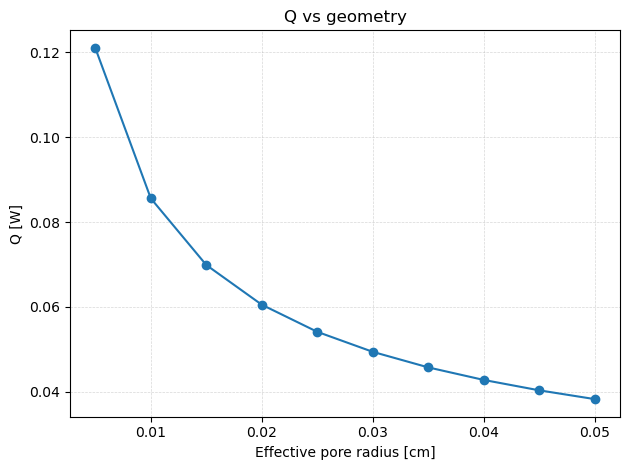

In [6]:

import numpy as np
r_eff_vals = np.linspace(0.005, 0.05, 10)  # cm
T = 850.0
f = props_for("sodium", T)
q_vals = []
for r in r_eff_vals:
    g2 = M_Geometry(radius_cm=geom.radius_cm, effective_pore_radius_cm=float(r), wavelength_cm=geom.wavelength_cm)
    lims = estimate_limits_cgs(lengths, g2, f, flags)
    q_vals.append(lims.q_capillary_W if lims.q_capillary_W is not None else 0.0)
plot_Q_vs_geometry(list(r_eff_vals), q_vals, xlabel="Effective pore radius [cm]");


## 5. Configuration I/O (JSON/YAML)

In [7]:

from heatpipe.io import load_config, dump_config_file, PipeConfig, Geometry, SectionLengths, FlowFlags, Option, SweepSpec
cfg_path = r"example_config.json"
cfg, run = load_config(cfg_path)
print("Loaded:", cfg)
# Save a modified copy
cfg2 = PipeConfig(fluid="sodium", theta_deg=0.0, geometry=Geometry(radius_cm=0.6, effective_pore_radius_cm=0.03, wavelength_cm=0.05), lengths=SectionLengths(L_e=30.0, L_a=20.0, L_c=30.0), flags=FlowFlags())
out_path = r"example_config_modified.json"
dump_config_file(out_path, cfg2, run)
print("Wrote", out_path)


Loaded: PipeConfig(fluid='sodium', theta_deg=0.0, geometry=Geometry(radius_cm=0.5, effective_pore_radius_cm=0.02, wavelength_cm=0.05, passages=6), lengths=SectionLengths(L_e=30.0, L_a=20.0, L_c=30.0), flags=FlowFlags(vapor_regime_evap=<Regime.laminar: 'laminar'>, vapor_regime_adiab=<Regime.turbulent: 'turbulent'>, vapor_regime_cond=<Regime.laminar: 'laminar'>))
Wrote example_config_modified.json


# Testing UQ frameworks

In [8]:
import sys, pathlib, numpy as np
from heatpipe.uq import UncertainInput, UQSpec, uq_monte_carlo, uq_pce, uq_gp, wilks_min_samples_one_sided
import pandas as pd
import matplotlib.pyplot as plt


## 1) Define UQ Spec

In [9]:

spec = UQSpec(inputs=[
    UncertainInput("radius_cm", "normal", {"mean":0.5, "std":0.02}, lower=0.3, upper=0.8),
    UncertainInput("effective_pore_radius_cm", "uniform", {"low":0.01, "high":0.04}),
    UncertainInput("wavelength_cm", "uniform", {"low":0.04, "high":0.06}),
    UncertainInput("L_e", "deterministic", {"value":30.0}),
    UncertainInput("L_a", "deterministic", {"value":20.0}),
    UncertainInput("L_c", "deterministic", {"value":30.0}),
    UncertainInput("T_K", "normal", {"mean":850.0, "std":30.0}),
])


## 2) Monte Carlo (LHS) + Wilks info

'Monte Carlo: Q_lim_W'

,Q_lim_W
0,0.073499
1,0.069175
2,0.041185
3,0.081006
4,0.052244
...,...
295,0.042903
296,0.094932
297,0.067372
298,0.040556


Empirical 5th percentile: 0.034 W  |  Wilks N (95/95 lower): 1


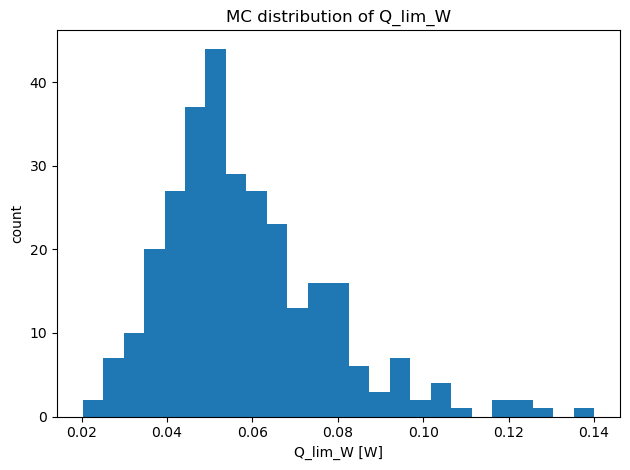

In [10]:

X, outs = uq_monte_carlo(spec, n=300, seed=7)
Q = outs["Q_lim_W"]
mask = ~np.isnan(Q)
Qv = Q[mask]
q05 = np.quantile(Qv, 0.05)
N95_lower = wilks_min_samples_one_sided(beta=0.95, gamma=0.95, side="lower")
df = pd.DataFrame({"Q_lim_W": Qv})
display("Monte Carlo: Q_lim_W", df)
print(f"Empirical 5th percentile: {q05:.3f} W  |  Wilks N (95/95 lower): {N95_lower}")
fig = plt.figure()
plt.hist(Qv, bins=25)
plt.title("MC distribution of Q_lim_W"); plt.xlabel("Q_lim_W [W]"); plt.ylabel("count"); fig.tight_layout()


## 3) PCE (order=2) + Sobol indices

In [11]:

pce, info = uq_pce(spec, n_train=250, order=2, seed=7)
S1, ST = pce.sobol_first_total()
print("PCE mean, std:", pce.mean, np.sqrt(pce.variance))
for name, s, st in zip(pce.input_names, S1, ST):
    print(f"{name:30s}  S1={s:.3f}  ST={st:.3f}")


PCE mean, std: 0.014530526158447613 0.028442394302201128
radius_cm                       S1=0.019  ST=0.022
effective_pore_radius_cm        S1=0.086  ST=0.097
wavelength_cm                   S1=0.000  ST=0.000
L_e                             S1=0.058  ST=0.116
L_a                             S1=0.058  ST=0.116
L_c                             S1=0.058  ST=0.116
T_K                             S1=0.099  ST=0.110


## 4) Gaussian Process surrogate

In [12]:

gp, ginfo = uq_gp(spec, n_train=150, seed=7)
mu, var = gp.predict(ginfo["X"])
print("GP in-sample RMSE:", np.sqrt(np.mean((mu - ginfo["y"])**2)))


GP in-sample RMSE: 1.7570512593109864e-06


## 5) Compare MC vs PCE vs GP on a fresh test set

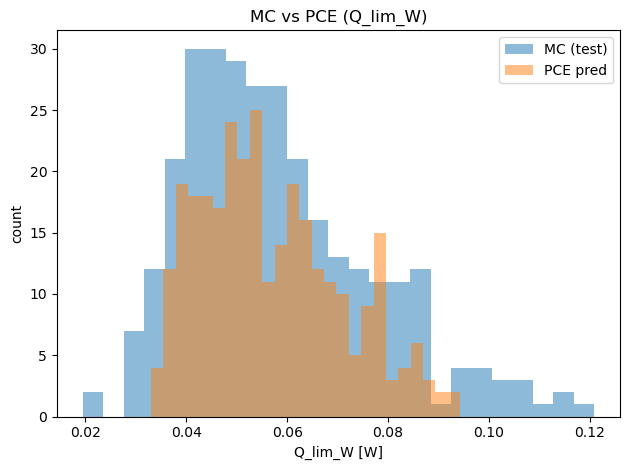

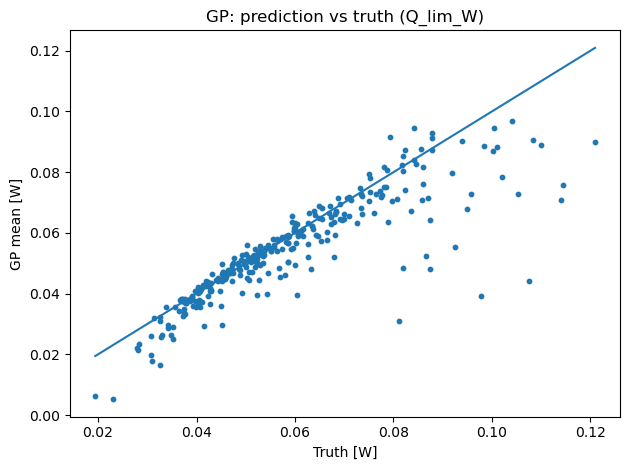

In [13]:

Xtest, outs_test = uq_monte_carlo(spec, n=300, seed=99)
# PCE prediction needs Z; approximate rank transform on Xtest for demo
U = np.zeros_like(Xtest)
for j in range(Xtest.shape[1]):
    r = np.argsort(np.argsort(Xtest[:,j]))
    U[:,j] = (r + 0.5)/Xtest.shape[0]

Z = np.sqrt(2.0) * np.vectorize(math.erf)(2.0*np.clip(U,1e-12,1-1e-12)-1.0)
yp = pce.predict(Z)
mu_t, var_t = gp.predict(Xtest)

fig = plt.figure()
plt.hist(outs_test["Q_lim_W"][~np.isnan(outs_test["Q_lim_W"])], bins=25, alpha=0.5, label="MC (test)")
plt.hist(yp, bins=25, alpha=0.5, label="PCE pred")
plt.title("MC vs PCE (Q_lim_W)"); plt.xlabel("Q_lim_W [W]"); plt.ylabel("count"); plt.legend(); fig.tight_layout()

fig = plt.figure()
plt.scatter(outs_test["Q_lim_W"], mu_t, s=10)
mn, mx = np.nanmin(outs_test["Q_lim_W"]), np.nanmax(outs_test["Q_lim_W"])
plt.plot([mn, mx], [mn, mx])
plt.title("GP: prediction vs truth (Q_lim_W)"); plt.xlabel("Truth [W]"); plt.ylabel("GP mean [W]"); fig.tight_layout()
